In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Data getting, cleaning, and exploring
from env import host, user, password
from acquire import get_connection, new_telco_data, get_telco_data
from prepare import clean_telco, impute_mode, train_validate_test_split,impute_mode, prep_telco_data
import explore

# Python without these is hard
import pandas as pd
import numpy as np
from pydataset import data

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import graphviz
from graphviz import Graph

# Data Aquisition 

In [7]:
sql_query = '''
    SELECT *
    FROM customers
    JOIN contract_types USING(`contract_type_id`)
    JOIN internet_service_types USING(`internet_service_type_id`)
    JOIN payment_types USING(payment_type_id);
            '''

In [8]:
get_db_url = f'mysql+pymysql://{user}:{password}@{host}/telco_churn'

In [9]:
df = pd.read_sql(sql_query, get_db_url)

In [10]:
df.shape

(7043, 24)

In [11]:
df.customer_id.drop_duplicates

<bound method Series.drop_duplicates of 0       0003-MKNFE
1       0013-MHZWF
2       0015-UOCOJ
3       0023-HGHWL
4       0032-PGELS
           ...    
7038    9950-MTGYX
7039    9953-ZMKSM
7040    9964-WBQDJ
7041    9972-EWRJS
7042    9975-GPKZU
Name: customer_id, Length: 7043, dtype: object>

In [12]:
df.shape

(7043, 24)

In [7]:
df.online_security.unique()

array(['No', 'Yes', 'No internet service'], dtype=object)

# Data Preparation

In [8]:
df.replace('No phone service', 'No', inplace=True)
df.replace('No internet service', 'No', inplace=True)
  

In [9]:
dummy_df = pd.get_dummies(df[['gender','contract_type','payment_type']], drop_first=True)
dummy2_df = pd.get_dummies(df[['internet_service_type']], drop_first=False)
dropcols = [
            'gender',
            'payment_type_id',
            'internet_service_type_id',
            'contract_type_id',
            'internet_service_type_none'
               ]

In [10]:
df = pd.concat([df, dummy_df,dummy2_df], axis=1)

In [11]:
df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('(','').str.replace(')','')

In [12]:
df.drop(columns=dropcols, inplace=True)

In [13]:
df.columns

Index(['customer_id', 'senior_citizen', 'partner', 'dependents', 'tenure',
       'phone_service', 'multiple_lines', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'paperless_billing', 'monthly_charges', 'total_charges', 'churn',
       'contract_type', 'internet_service_type', 'payment_type', 'gender_male',
       'contract_type_one_year', 'contract_type_two_year',
       'payment_type_credit_card_automatic', 'payment_type_electronic_check',
       'payment_type_mailed_check', 'internet_service_type_dsl',
       'internet_service_type_fiber_optic'],
      dtype='object')

In [14]:
df.columns = ['customer_id',
 'senior_citizen',
 'partner',
 'dependents',
 'tenure',
 'phone_service',
 'multiple_lines',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'paperless_billing',
 'monthly_charges',
 'total_charges',
 'churn',
 'contract_type',
 'internet_service_type',
 'payment_type',
 'gender_male',
 'one_year_contract',
 'two_year_contract',
 'credit_card_payment',
 'e_check_payment',
 'mailed_check_payment',
 'dsl_internet',
 'fiber_optic_internet']

In [15]:
df.total_charges = pd.to_numeric(df.total_charges, errors='coerce').astype('float64')

In [16]:
df.total_charges = df.total_charges.fillna(0)

In [17]:
quant_vars = ['tenure','monthly_charges','total_charges']
cat_vars = list((df.columns).drop(quant_vars))

In [18]:
df1 = df[df.isna().any(axis=1)].drop(columns=cat_vars)

In [19]:
df1.head()

,tenure,monthly_charges,total_charges


In [20]:
df1.total_charges = df1.total_charges.fillna(value=0)

In [21]:
df1.total_charges.isnull().sum()

0

In [22]:
df = df.replace("Yes", 1).replace("No", 0)

In [23]:
df.monthly_charges.describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: monthly_charges, dtype: float64

In [24]:
train, validate, test = train_validate_test_split(df)
target = 'churn'

In [25]:
train.shape, validate.shape, test.shape

((3943, 28), (1691, 28), (1409, 28))

In [26]:
train.head()

,customer_id,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,...,internet_service_type,payment_type,gender_male,one_year_contract,two_year_contract,credit_card_payment,e_check_payment,mailed_check_payment,dsl_internet,fiber_optic_internet
5670,2739-CCZMB,0,0,1,5,1,0,0,0,0,...,None,Credit card (automatic),1,0,0,1,0,0,0,0
4152,8035-PWSEV,0,0,0,6,1,0,0,0,1,...,Fiber optic,Electronic check,0,0,0,0,1,0,0,1
4890,6250-CGGUN,0,0,0,54,1,0,1,0,1,...,Fiber optic,Electronic check,1,1,0,0,1,0,0,1
2391,9499-XPZXM,0,1,0,72,1,1,1,1,0,...,DSL,Bank transfer (automatic),0,0,1,0,0,0,1,0
2896,2305-MRGLV,0,1,0,28,1,0,0,0,0,...,Fiber optic,Bank transfer (automatic),1,0,0,0,0,0,0,1


In [46]:
train1 = train.drop(columns=[
 'senior_citizen',
 'partner',
 'dependents',
 'tenure',
 'phone_service',
 'multiple_lines',
 'paperless_billing',
 'monthly_charges',
 'total_charges',
 'contract_type',
 'internet_service_type',
 'payment_type',
 'gender_male',
 'one_year_contract',
 'two_year_contract',
 'credit_card_payment',
 'e_check_payment',
 'mailed_check_payment',
 'dsl_internet',
 'fiber_optic_internet'])

In [47]:
train_melt = train1.melt(id_vars=['customer_id', 'churn'], var_name='online_services')

In [48]:
train_melt = train_melt.groupby('customer_id').sum()

In [51]:
train_melt['churn'] = train_melt.churn.replace(6, 1)

In [55]:
train_melt.sample(10)

,churn,value
customer_id,,
0219-YTZUE,1,2
0266-CLZKZ,0,4
9036-CSKBW,0,5
7319-ZNRTR,0,0
6818-DJXAA,0,3
5862-BRIXZ,0,5
1150-FTQGN,0,3
8185-UPYBR,1,0
9840-EFJQB,0,1


value 
_____________________

         chi2       p-value  degrees of freedom
0  181.338313  1.763412e-36                   6

observed:
 churn     0     1   All
value                  
0       973   280  1253
1       301   229   530
2       383   209   592
3       448   175   623
4       375   104   479
5       272    41   313
6       145     8   153
All    2897  1046  3943

expected:
             0           1
0  920.603855  332.396145
1  389.401471  140.598529
2  434.954096  157.045904
3  457.730408  165.269592
4  351.930763  127.069237
5  229.967284   83.032716
6  112.412123   40.587877


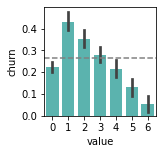


_____________________



In [53]:
explore.explore_bivariate_categorical(train_melt, 'churn', 'value')

value 
____________________



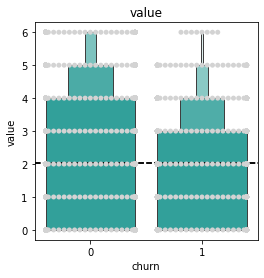

        count      mean       std  min  25%  50%  75%  max
churn                                                     
0      2897.0  2.119779  1.937155  0.0  0.0  2.0  4.0  6.0
1      1046.0  1.760038  1.508118  0.0  0.0  2.0  3.0  6.0 


Mann-Whitney Test:
 MannwhitneyuResult(statistic=1633024.0, pvalue=0.00013287620392759555)

____________________



In [54]:
explore.explore_bivariate_quant(train_melt, 'churn', 'value')